*** This colab is an adaptation of David Dale's colab of a similar problem, tranlating Tyvan.
His orginal colab is linked here: https://colab.research.google.com/drive/1bayEaw2fz_9Mhg9jFFZhrmDlQlBj1YZf?usp=sharing

In this notebook, I show how to fine-tune a NLLB-200 machine translation model for a new language.

The new language will be [Hittite](https://en.wikipedia.org/wiki/), and I will use a Hittite-English parallel corpus as the training data.


I am running this notebook on Google Colab with a T4 GPU that has 15Gb of memory. If you run it elsewhere, you may want to adjust the batch size, so that there are no OOM errors, but the GPU is well utilized.

# 0. Preliminaries

I run this notebook in Google Colab (which is ephemeral), and to read the dataset and to write the resulting model I use Google Drive, which I mount in the cell below.

In [1]:
# where I loaded in my train and test file paths
from google.colab import drive
import os
if not os.path.exists('/gd'):
    drive.mount('/content/drive')
    dataset_file_path = "/content/drive/MyDrive/Colab Notebooks/MainDataset.json"

Mounted at /content/drive


Installing dependencies:
* `transformers`, as a neural network framework
* `sentencepiece`, a backend for my tokenizer (the algorithm for converting a text into symbols from the model's vocabulary)
* `sacremoses`, a package required for text preprocessing with which NLLB models were pretrained.
* `sacrebleu`, a package for evaluating translation models

In [2]:
import locale
def gpe(x=None):
    return "UTF-8"
locale.getpreferredencoding = gpe

In [3]:
!pip install sentencepiece transformers==4.33 datasets sacremoses sacrebleu  -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.9 MB/s eta 0:00:00


# 1. Exploring the data

In this section, I try to understand what is the training data that I have, and how suitable it is for fine-tuning a NLLB model.

In [4]:
import pandas as pd
import json

In [10]:
def json_to_pandas(path):
  dataset = []
  with open(dataset_file_path) as F:
    for l in F.readlines():
      l = json.loads(l)
      newL = dict()
      if l['Hittite']:
        newL['src_lang'] = l['Hittite']
        newL['tgt_lang'] = l['Translation']
      dataset.append(newL)

  df = pd.DataFrame.from_dict(dataset)
  return df


df = json_to_pandas(dataset_file_path)

print(df.shape)
print(df.columns)

(3144, 2)
Index(['src_lang', 'tgt_lang'], dtype='object')


In [11]:
pd.options.display.max_colwidth = 100

In [12]:
df.sample(10)

,src_lang,tgt_lang
986,tissāi,to form.
244,hassant,born (part.
2601,šātar,irritation(?)
1555,LÚḫimmalli-,"imitator, vel sim."
687,palāumnili,adv.
2628,šiela-,of one
1893,A.ŠÀkuera-,"field parcel, territory, area"
1168,alparama-,"cloudiness, layer of clouds"
2715,taḫš-,to predict
1185,annanuḫḫa-,trained (?)


In [13]:
from sklearn.model_selection import train_test_split
from datasets import Dataset

df_train=df.sample(frac=0.9,random_state=200)
df_test=df.drop(df_train.index)

dataset_train = Dataset.from_pandas(df_train)
dataset_test = Dataset.from_pandas(df_test)

print(dataset_train)
print(dataset_test)

Dataset({
    features: ['src_lang', 'tgt_lang', '__index_level_0__'],
    num_rows: 2830
})
Dataset({
    features: ['src_lang', 'tgt_lang', '__index_level_0__'],
    num_rows: 314
})


# 2. How well does the data fit into a NLLB tokenizer?

In [10]:
from transformers import NllbTokenizer
from tqdm.auto import tqdm, trange

In [15]:
tokenizer = NllbTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.55k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

In [16]:
import re

def word_tokenize(text):
    # a very naive word tokenizer for languages with English-like orthography
    return re.findall('(\w+|[^\w\s])', text)

In [17]:
smpl = df_train.sample(1000, random_state=1, replace='true')

smpl['eng_toks'] = smpl.tgt_lang.apply(tokenizer.tokenize)
smpl['hit_toks'] = smpl.src_lang.apply(tokenizer.tokenize)

smpl['eng_words'] = smpl.tgt_lang.apply(word_tokenize)
smpl['hit_words'] = smpl.src_lang.apply(word_tokenize)

In [18]:
smpl.sample(5)[['src_lang', 'hit_words', 'hit_toks', 'tgt_lang', 'eng_words', 'eng_toks']]

,src_lang,hit_words,hit_toks,tgt_lang,eng_words,eng_toks
3135,(GIŠ)zeriyalli-,"[(, GIŠ, ), zeriyalli, -]","[▁(, GI, Š, ), z, eri, yal, li, -]",cup-holder,"[cup, -, holder]","[▁cup, -, holder]"
3140,zinu-zi / zainu-zi,"[zinu, -, zi, /, zainu, -, zi]","[▁z, inu, -, zi, ▁/, ▁za, inu, -, zi]",to make cross,"[to, make, cross]","[▁to, ▁make, ▁cross]"
2854,*teriyankiš(?),"[*, teriyankiš, (, ?, )]","[▁*, teri, yan, ki, š, (, ?)]",thrice,[thrice],"[▁th, rice]"
983,arga,[arga],[▁arga],to go out ? awan arha t.,"[to, go, out, ?, awan, arha, t, .]","[▁to, ▁go, ▁out, ▁?, ▁awan, ▁ar, ha, ▁t, .]"
2314,papraḫḫ-i,"[papraḫḫ, -, i]","[▁pap, ra, ḫḫ, -, i]","to defile, to make impure","[to, defile, ,, to, make, impure]","[▁to, ▁de, file, ,, ▁to, ▁make, ▁imp, ure]"


In [19]:
stats = smpl[['eng_toks', 'hit_toks', 'eng_words', 'hit_words']].applymap(len).describe()
stats

,eng_toks,hit_toks,eng_words,hit_words
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,6.294000,5.412000,5.454000,3.051000
std,6.509373,3.879601,6.279914,2.915287
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,2.000000,1.000000
50%,5.000000,4.500000,4.000000,2.000000
75%,8.000000,7.000000,7.000000,5.000000
max,117.000000,45.000000,121.000000,37.000000


In [20]:
print("eng tokens per word: ", stats.eng_toks['mean'] / stats.eng_words['mean'])
print("hit tokens per word: ", stats.hit_toks['mean'] / stats.hit_words['mean'])

eng tokens per word:  1.154015401540154
hit tokens per word:  1.7738446411012783


In [21]:
print(tokenizer.unk_token, tokenizer.unk_token_id)

<unk> 3


**How often does the <unk> token happen in the tokenizer output for Hittite? If this is too often, we need to fix it somehow**

In [22]:
texts_with_unk = [text for text in tqdm(df.src_lang) if tokenizer.unk_token_id in tokenizer(text).input_ids]
print("Unique hit_tokens (<unk>): ", len(texts_with_unk))

  0%|          | 0/3144 [00:00<?, ?it/s]

Unique hit_tokens (<unk>):  564


In [23]:
# Show text samples that produce the unique token <unk>
# More than likely due to the unique character accents
import random
s = random.sample(texts_with_unk, 5)
s

['išḫaḫruwe/a-tta(ri)',
 'kariantašḫa-',
 '(GIŠ)ḫarpa/i-',
 'mēḫur',
 'nekuz meḫur']

*Apparently, most of the texts with unknown tokens just have some punctuation unfamiliar to the NLLB tokenizer.*

*This is because the NLLB model was pretrained on normalized texts. If we reproduce the normalization, most of the problems would be fixed.*

!!! Though this was true for the example that we adapted this colab from, it is not true for our Hittite implementation. As demonstrated below !!!

In [25]:
# this code is adapted from  the Stopes repo of the NLLB team
# https://github.com/facebookresearch/stopes/blob/main/stopes/pipelines/monolingual/monolingual_line_processor.py#L214

import re
import sys
import typing as tp
import unicodedata
from sacremoses import MosesPunctNormalizer


mpn = MosesPunctNormalizer(lang="en")
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]


def get_non_printing_char_replacer(replace_by: str = " ") -> tp.Callable[[str], str]:
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))
        # same as \p{C} in perl
        # see https://www.unicode.org/reports/tr44/#General_Category_Values
        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    # replace 𝓕𝔯𝔞𝔫𝔠𝔢𝔰𝔠𝔞 by Francesca
    clean = unicodedata.normalize("NFKC", clean)
    return clean

In [25]:
texts_with_unk_normed = [text for text in tqdm(texts_with_unk) if tokenizer.unk_token_id in tokenizer(preproc(text)).input_ids]
print("Unique hit_tokens (<unk>): ", len(texts_with_unk_normed))

  0%|          | 0/564 [00:00<?, ?it/s]

Unique hit_tokens (<unk>):  549


After normalizing texts, we still see about the same number of unk tokens. Good evidence that we need to update the tokenizer vocabulary to use it with Hittite.

# 3 (optional). Expanding the vocabulary

Below I'm putting the text together and preprocessing it. Then, I'm forcing the tokenizer to include all characters that appear more than 3 times in our data set. (As characters that appear once or twice more than likely won't be learned by the network anyways.)

In [26]:
from collections import Counter
all_texts = df_train.src_lang.dropna().tolist()
all_text_normalized = [preproc(t) for t in tqdm(all_texts)]
chars_cnt = Counter(c for t in all_text_normalized for c in t)
required_chars = ''.join([
    k for k, v in chars_cnt.most_common()
    if v >= 3 and k not in ' '
])

  0%|          | 0/2830 [00:00<?, ?it/s]

Below I use the SentencePiece algorithm to train a Hittite tokenizer. I choose for the vocabulary size to be 2187, which is much smaller than the orginal example, but the highest value the function will allow.

In [27]:
import sentencepiece as spm
all_texts_file = 'hittite_texts_plain.txt'
SPM_PREFIX = 'spm_hittite_2k'
with open(all_texts_file, 'w', encoding='utf-8') as f:
    for i, text in enumerate(all_texts):
        print(text, file=f)

spm.SentencePieceTrainer.train(
    input=all_texts_file,
    model_prefix=SPM_PREFIX,
    vocab_size=2187,  # 2K
    character_coverage = 1,
    num_threads=16,
    train_extremely_large_corpus=False,
    add_dummy_prefix=False,
    max_sentencepiece_length=128,
    max_sentence_length=4192*4,
    pad_id=0,
    eos_id=1,
    unk_id=2,
    bos_id=-1,
    required_chars=required_chars,
)

Below the standard nllb tokenizer is "enriched" with all the tokens from the hittite tokenizer missing from the nllb tokenizer. This is done by extracting the sentencepiece model from the standard nllb tokenizer.

In [28]:
from sentencepiece import sentencepiece_model_pb2 as sp_pb2_model
# At this step, the code may throw an error about protobuf. Do as it tells.
from transformers import NllbTokenizer

# reading the NLLB and the Tyvan sentencepiece models into a native format
tokenizer = NllbTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')
sp_trained = spm.SentencePieceProcessor(model_file=f'{SPM_PREFIX}.model')
added_spm = sp_pb2_model.ModelProto()
added_spm.ParseFromString(sp_trained.serialized_model_proto())
old_spm = sp_pb2_model.ModelProto()
old_spm.ParseFromString(tokenizer.sp_model.serialized_model_proto())

# adding the missing tokens to the NLLB sentencepiece model
nllb_tokens_set = {p.piece for p in old_spm.pieces}
prev_min_score = old_spm.pieces[-1].score
for p in added_spm.pieces:
    piece = p.piece
    if piece not in nllb_tokens_set:
        new_p = sp_pb2_model.ModelProto().SentencePiece()
        new_p.piece = piece
        # for all new tokens, I'll set a lower score (priority)
        new_p.score = p.score + prev_min_score
        old_spm.pieces.append(new_p)

# saving the result to disk
NEW_SPM_NAME = 'spm_nllb_hittite_268k.model'
with open(NEW_SPM_NAME, 'wb') as f:
    f.write(old_spm.SerializeToString())

Finally, I update the network's weights below by adding the new embedding for the newly added tokens. The number of new tokens is printed.

In [29]:
from transformers import AutoModelForSeq2SeqLM
model_name = 'facebook/nllb-200-distilled-600M'
# loading the tokenizers
tokenizer_old = NllbTokenizer.from_pretrained(model_name)
tokenizer = NllbTokenizer.from_pretrained(model_name, vocab_file=NEW_SPM_NAME)
print(len(tokenizer_old), len(tokenizer)) # 256204, 268559
added_vocab = set(tokenizer.get_vocab()).difference(set(tokenizer_old.get_vocab()))
print(len(added_vocab))  # 12355

# loading and resizing the model
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))

# re-initializing the new embeddings
for t in tqdm(added_vocab):
    tt = tokenizer_old(t, add_special_tokens=False).input_ids
    if len(tt) == 0:
        tt = [tokenizer_old.unk_token_id]
    idx = tokenizer.convert_tokens_to_ids(t)
    model.model.shared.weight.data[idx] = model.model.shared.weight.data[tt].mean(0)

256204 257670
1465


config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 257670. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


  0%|          | 0/1465 [00:00<?, ?it/s]

Below I test again to see the number of <unk> tokens produced by the our now modified tokenizer is zero. Meaning training the tokenizer was successful.

In [30]:
texts_with_unk_normed = [text for text in tqdm(texts_with_unk) if tokenizer.unk_token_id in tokenizer(preproc(text)).input_ids]
print("Unique hit_tokens (<unk>): ", len(texts_with_unk_normed))

  0%|          | 0/564 [00:00<?, ?it/s]

Unique hit_tokens (<unk>):  0


# 4. Adding a new language tag to the tokenizer and model

In [11]:
from transformers import AutoModelForSeq2SeqLM
from transformers import NllbTokenizer

In [32]:
tokenizer = NllbTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')
print(len(tokenizer))
print(tokenizer.convert_ids_to_tokens([256203, 256203]))

256204
['<mask>', '<mask>']


In [33]:
def fix_tokenizer(tokenizer, new_lang='hit_Tite'): # <-- hittite
    """
    Add a new language token to the tokenizer vocabulary
    (this should be done each time after its initialization)
    """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [34]:
fix_tokenizer(tokenizer)

In [35]:
print(tokenizer.convert_ids_to_tokens([256047, 256203, 256204])) # ['eng_Latn', 'hit_Tite', '<mask>']
print(tokenizer.convert_tokens_to_ids(['hit_Tite', 'eng_Latn', '<mask>'])) # [256203, 256047, 256204]
# this is consistent now, wow!

['eng_Latn', 'hit_Tite', '<mask>']
[256203, 256047, 256204]


**This is where we initialize the new language tag for the model**

In [36]:
# fixing the new/moved token embeddings in the model
added_token_id = tokenizer.convert_tokens_to_ids('hit_Tite')
similar_lang_id = tokenizer.convert_tokens_to_ids('tur_Latn') # <-- needs research!!!
print(added_token_id, similar_lang_id)

256203 256184


In [37]:
model = AutoModelForSeq2SeqLM.from_pretrained('facebook/nllb-200-distilled-600M')
model.resize_token_embeddings(len(tokenizer))

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(256205, 1024)

In [ ]:
# moving the embedding for "mask" to its new position
model.model.shared.weight.data[added_token_id+1] = model.model.shared.weight.data[added_token_id]
# initializing new language token with a token of a similar language
model.model.shared.weight.data[added_token_id] = model.model.shared.weight.data[similar_lang_id]

# 5. Preparing the training loop

In [5]:
import gc
import random
import numpy as np
import torch
from tqdm.auto import tqdm, trange
from transformers.optimization import Adafactor
from transformers import get_constant_schedule_with_warmup

def cleanup():
    """Try to free GPU memory"""
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

In [ ]:
model.cuda();

In [ ]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

In [42]:
losses = []
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=1_000)

In [ ]:
batch_size = 16  # 32 doesn't fit well to 15GB of GPU memory, may need to
                  # decrease to 16.
max_length = 128
warmup_steps = 1_000
training_steps = 10000

In [26]:
LANGS = [('src_lang', 'hit_Tite'), ('tgt_lang', 'eng_Latn')]

def get_batch_pairs(batch_size, data=df_train):
    (l1, long1), (l2, long2) = random.sample(LANGS, 2)
    xx, yy = [], []
    for _ in range(batch_size):
        item = df_train.iloc[random.randint(0, len(data)-1)]
        xx.append(preproc(item[l1]))
        yy.append(preproc(item[l2]))
    return xx, yy, long1, long2

print(get_batch_pairs(1))

(['āššu- / āššaw-'], ['good; dear; favourable'], 'hit_Tite', 'eng_Latn')


# 6. The training loop

In [47]:
MODEL_SAVE_PATH = "/content/drive/MyDrive/Colab Notebooks/hittite_saved_model"

In [48]:

x, y, loss = None, None, None
cleanup()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 1000 == 0:
        print(i, np.mean(losses[-1000:]))

    if i % 1000 == 0 and i > 0:
        model.save_pretrained(MODEL_SAVE_PATH)
        tokenizer.save_pretrained(MODEL_SAVE_PATH)


  0%|          | 0/9780 [00:00<?, ?it/s]

1000 2.8668809345960615
2000 0.9582559912800789
3000 0.29148687563836573
4000 0.14581684464681893
5000 0.10421363664977253
6000 0.07745025246217847
7000 0.07136123656760901
8000 0.06059448098565917
9000 0.05420401303365361


# Push to Hub

In [14]:
!git config --global credential.helper store
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) 
Token is valid (permission: write).
Your token has been saved in your conf

In [15]:
model.push_to_hub("ryfye181/hittite_saved_model")
tokenizer.push_to_hub("ryfye181/hittite_saved_model")

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ryfye181/hittite_saved_model/commit/8b3725b06366e0da63b2ede41ede0916d95310a4', commit_message='Upload tokenizer', commit_description='', oid='8b3725b06366e0da63b2ede41ede0916d95310a4', pr_url=None, pr_revision=None, pr_num=None)

# 7. Tests and Metrics


In [49]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM, AutoConfig
from tqdm.auto import tqdm, trange

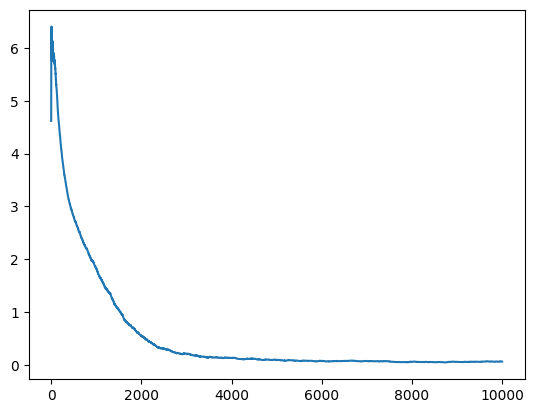

In [50]:
pd.Series(losses).ewm(100).mean().plot();

In [51]:
# this code is adapted from  the Stopes repo of the NLLB team
# https://github.com/facebookresearch/stopes/blob/main/stopes/pipelines/monolingual/monolingual_line_processor.py#L214

import re
import sys
import typing as tp
import unicodedata
from sacremoses import MosesPunctNormalizer


mpn = MosesPunctNormalizer(lang="en")
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]


def get_non_printing_char_replacer(replace_by: str = " ") -> tp.Callable[[str], str]:
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))
        # same as \p{C} in perl
        # see https://www.unicode.org/reports/tr44/#General_Category_Values
        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    # replace 𝓕𝔯𝔞𝔫𝔠𝔢𝔰𝔠𝔞 by Francesca
    clean = unicodedata.normalize("NFKC", clean)
    return clean

In [52]:
def fix_tokenizer(tokenizer, new_lang='hit_Tite'):
    """ Add a new language token to the tokenizer vocabulary (this should be done each time after its initialization) """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [53]:
def translate(text, src_lang='hit_Tite', tgt_lang='eng_Latn', a=32, b=3, max_input_length=1024, num_beams=4, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        num_beams=num_beams,
        **kwargs
    )
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [27]:

xx, yy, lang1, lang2 = get_batch_pairs(1, data=df_test)
print("English Test:", xx)
print("Hittite Test:", yy)
model.eval()
print(f"Model prediction on {xx}:",
      translate(xx[0], lang1, lang2, no_repeat_ngram_size=3, num_beams=5))


English Test: ['(LÚ) miyaḫuntēšš-zi']
Hittite Test: ['to become an old man']
Model prediction on ['(LÚ) miyaḫuntēšš-zi']: ['to become an old man']


**Main Metrics**

In [36]:
df_test['hit_translated'] = [translate(t, 'hit_Tite', 'eng_Latn')[0] for t in tqdm(df_test.src_lang)]
df_test['eng_translated'] = [translate(t, 'eng_Latn', 'hit_Tite')[0] for t in tqdm(df_test.tgt_lang)]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

In [38]:
import sacrebleu
chrf_calc = sacrebleu.CHRF(word_order=2)  # this metric is called ChrF++

In [39]:
xx, yy = ['allaniya'], ['to sweat.']
print(chrf_calc.corpus_score(xx, [yy]))
print(chrf_calc.corpus_score(yy, [xx]))

chrF2++ = 1.79
chrF2++ = 1.79


In [40]:
print(chrf_calc.corpus_score(df_test['hit_translated'].tolist(), [df_test['tgt_lang'].tolist()])) # (test value, true value)
print(chrf_calc.corpus_score(df_test['eng_translated'].tolist(), [df_test['src_lang'].tolist()])) # (test value, true value)

chrF2++ = 15.45
chrF2++ = 15.78


In [41]:
# Show predicted output vs true label comparison

pd.options.display.max_colwidth = 100
df_test.sample(10, random_state=200)[['src_lang', 'tgt_lang', 'eng_translated', 'hit_translated']]

,src_lang,tgt_lang,eng_translated,hit_translated
1756,kallar-,"inauspicious, unpropitious, baleful, enormous",kallareššar / kallarešn-,exaggerator
2077,« mamanna-,to look at,šu-,girl
847,sipand,to make a libation; − (with an animal as object =) to spill the blood of an animal.,ēšpantu,sleep.
460,kessera,hand (id.,tarpanalla,the open flame.
2133,mašiyanki,however many times,mašiyant-,"however, as much as, how many (times)"
2058,maknu-zi,"to make abundant, to increase, to multiply",šan (i) -zi,to maknu
1569,"ḫuini-zi, ḫuni-zi",to make run,ūn-i / ūn-,"to buy, to sell, to deliver, to dispense"
3049,wātarnaḫḫ-i,"to order, to instruct",āš-zi,"to reinforce, to strengthen"
184,handais,heat.,hūmar,to handae-zi
162,LÚhaliyatalla,guard of a temple.,LÚweheskattalla,"administrator, deputy."


In [70]:
# Write the output comparison to a csv file

output = df_test.sample(300, random_state=200)[['src_lang', 'tgt_lang', 'eng_translated', 'hit_translated']]
output.to_csv('output.csv', index=False)

# 8. Using the Model

In [28]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM, AutoConfig

In [29]:
# Load model and tokenizer

model_load_name = "ryfye181/hittite_saved_model"
model = AutoModelForSeq2SeqLM.from_pretrained(model_load_name).cuda()
tokenizer = NllbTokenizer.from_pretrained(model_load_name)

config.json:   0%|          | 0.00/922 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.56k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [30]:
# "Fix" tokenizer

def fix_tokenizer(tokenizer, new_lang='hit_Tite'):
    """ Add a new language token to the tokenizer vocabulary (this should be done each time after its initialization) """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

fix_tokenizer(tokenizer)

In [31]:
# Get dataset as pandas data frame

dataset_file_path = "/content/drive/MyDrive/Colab Notebooks/MainDataset.json"

def json_to_pandas(path):
  dataset = []
  with open(dataset_file_path) as F:
    for l in F.readlines():
      l = json.loads(l)
      newL = dict()
      if l['Hittite']:
        newL['src_lang'] = l['Hittite']
        newL['tgt_lang'] = l['Translation']
      dataset.append(newL)

  df = pd.DataFrame.from_dict(dataset)
  return df


df = json_to_pandas(dataset_file_path)

print(df.shape)
print(df.columns)

(3144, 2)
Index(['src_lang', 'tgt_lang'], dtype='object')


In [32]:
# Create datasplits as done in training

df_train=df.sample(frac=0.9,random_state=200)
df_devtest=df.drop(df_train.index)
df_dev, df_test = train_test_split(df_devtest, test_size=0.5, random_state=200)

In [33]:
# Define translate function

def translate(text, src_lang='hit_Tite', tgt_lang='eng_Latn', a=16, b=1.5, max_input_length=1024, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        **kwargs
    )
    #print(inputs.input_ids.shape[1], result.shape[1])
    return tokenizer.batch_decode(result, skip_special_tokens=True)


**Single Translations**

In [34]:
t = "wet"
print(translate(t, 'eng_Latn', 'hit_Tite'))
t = "atis"
print(translate(t, 'hit_Tite', 'eng_Latn'))

['apae-']
['axe.']


In [35]:
t = "atis"
translate(t, 'hit_Tite', 'eng_Latn', do_sample=True, num_beams=1, temperature=1.5)

['axe.']

**Batched Translations**

In [21]:
def batched_translate(texts, batch_size=16, **kwargs):
    """Translate texts in batches of similar length"""
    idxs, texts2 = zip(*sorted(enumerate(texts), key=lambda p: len(p[1]), reverse=True))
    results = []
    for i in trange(0, len(texts2), batch_size):
        results.extend(translate(texts2[i: i+batch_size], **kwargs))
    return [p for i, p in sorted(zip(idxs, results))]

In [37]:
hit_translated = batched_translate(df_test.src_lang, src_lang='hit_Tite', tgt_lang='eng_Latn')

  0%|          | 0/10 [00:00<?, ?it/s]